In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from eumap.misc import find_files, ttprint, nan_percentile, GoogleSheet
from eumap.raster import read_rasters, save_rasters
import warnings
import multiprocess as mp
import time
from scipy.special import expit, logit
import warnings
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, cross_val_score, HalvingGridSearchCV, KFold, GroupKFold, cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor
import joblib
import pickle
from sklearn.metrics import r2_score, mean_squared_error, make_scorer#, root_mean_squared_error
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
# from cubist import Cubist
from sklearn.base import BaseEstimator, TransformerMixin
from pathlib import Path
from benchmark_pipeline import read_features, run_cumusort, parameter_fine_tuning, evaluate_model, calc_ccc, separate_data, accuracy_plot, calc_metrics
### input
folder = 'http://192.168.1.30:8333/ai4sh-landmasked/model_benchmark'
# from log_back_transform_rf import TreesRandomForestRegressor

prop_list = ['ocd','oc','bulk_density', 'ph_cacl2','ph_h2o','N','caco3','K','EC','P','CEC','texture1','texture2'] # unitl N everything has lightGBM models
space_list = ['log1p','log1p','normal', 'normal','normal','log1p','log1p','log1p','log1p','log1p','log1p','log1p','log1p'] # 
filt_list = [5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5] #5,5,5,5,

In [2]:
# set up
cv = GroupKFold(n_splits=5) 
rsl = []
prop = 'ocd'
space = 'log1p'
output_folder = f'/home/opengeohub/xuemeng/work_xuemeng/soc/results_new/{prop}'
tgt = f'{prop}_log1p'

new = pd.read_csv('/home/opengeohub/xuemeng/work_xuemeng/soc/result_paper/data_new.points_overlayed.csv',low_memory=False)
new.loc[new['ocd']<0, 'ocd'] = 0
new['ocd_log1p'] = np.log1p(new['ocd'])


# model
pathm = f'/home/opengeohub/xuemeng/work_xuemeng/soc/results_new/{prop}/model_rf.{prop}_ccc.joblib'
model = joblib.load(pathm)
# model.n_jobs=90

# covariates
pathc = f'/home/opengeohub/xuemeng/work_xuemeng/soc/results_new/{prop}/benchmark_selected.covs_{prop}.txt'
covs = read_features(pathc) 

# data
train = pd.read_csv('/home/opengeohub/xuemeng/work_xuemeng/soc/result_paper/data_ocd_train.csv',low_memory=False)
train = train.dropna(subset=covs+[tgt],how='any')

new = new.dropna(subset=covs+[tgt],how='any')
train = pd.concat([train,new])

test = pd.read_csv('/home/opengeohub/xuemeng/work_xuemeng/soc/result_paper/data_ocd_test.csv',low_memory=False)
test = test.dropna(subset=covs+[tgt],how='any')

In [38]:
len(new)

5454

In [3]:
for ii in [tgt]:
    if train[ii].isna().sum()>0:
        print(ii)
                            

In [4]:

# 5-fold spatial cv
ttprint('CV')
y_cv = cross_val_predict(model, train[covs], train[tgt], cv=cv, groups=train['tile_id'], n_jobs=60)
y_cv = np.around(y_cv, decimals=1, out=None)
mae_cv, medae_cv, mape_cv, ccc_cv, r2_cv, bias_cv = calc_metrics(train[tgt], y_cv, space)
# r2_cv, mae_cv, ccc_cv = accuracy_plot(train[tgt], y_cv, space, '5-fold spatial CV', output_folder=output_folder, show_range = [show_low, show_high], vmax=10) 
     
rsl.append({
    'method': '5-fold spatial CV',
    'MAE': mae_cv,
    'MAPE':mape_cv,
    'MedAE': medae_cv,
    'R2': r2_cv,
    'CCC': ccc_cv,
    'bias': bias_cv
    # 'cv_time (s)': cv_time
})

# test
ttprint('test')
model.fit(train[covs], train[tgt])
y_val = model.predict(test[covs])
y_val = np.around(y_val, decimals=1, out=None)
mae_val, medae_val, mape_val, ccc_val, r2_val, bias_val = calc_metrics(test[tgt], y_val, space)
# r2_val, mae_val, ccc_val = accuracy_plot(test[tgt], y_val, space, 'Independent test', output_folder=output_folder,show_range = [show_low, show_high], vmax=3) 
# error_spatial_plot(test[tgt], y_val, test['lat'], test['lon'], figure_name+ '-test', output_folder=output_folder)
# sorted_plot(test[tgt],y_val, figure_name+ '-test', output_folder=output_folder)

rsl.append({
    'method': 'individual validation data',
    'MAE': mae_val,
    'MAPE': mape_val,
    'MedAE': medae_val,
    'R2': r2_val,
    'CCC': ccc_val,
    'bias': bias_val
    # 'cv_time (s)': cv_time
})
rsl = pd.DataFrame(rsl)
rsl

[10:47:35] CV
[10:48:12] test


,method,MAE,MAPE,MedAE,R2,CCC,bias
0,5-fold spatial CV,7.462722,1.144803e+14,3.278908,0.706978,0.824770,-2.791904
1,individual validation data,8.110446,4.274908e-01,3.465345,0.746052,0.852137,-4.288887


In [5]:
print(np.min(y_val),np.max(y_val))

0.5056743497371368 4.6116698916458665


In [5]:
data = {
    "method": ["5-fold spatial CV", "individual validation data"],
    "MAE": [8.645408, 7.743001],
    "MAPE": [0.538194, 0.448666],
    "MedAE": [4.263586, 3.513991],
    "R2": [0.709098, 0.776355],
    "CCC": [0.827211, 0.868530],
    "bias": [-2.959056, -3.160186]
}

rsl_old = pd.DataFrame(data)
rsl_old

,method,MAE,MAPE,MedAE,R2,CCC,bias
0,5-fold spatial CV,8.645408,0.538194,4.263586,0.709098,0.827211,-2.959056
1,individual validation data,7.743001,0.448666,3.513991,0.776355,0.868530,-3.160186


In [6]:
rsl_compare = pd.concat([rsl,rsl_old])
rsl_compare = rsl_compare.transpose()
rsl_compare.columns = ['CV-new', 'individual-new', 'CV-old', 'individual-old']
rsl_compare

,CV-new,individual-new,CV-old,individual-old
method,5-fold spatial CV,individual validation data,5-fold spatial CV,individual validation data
MAE,7.462722,8.110446,8.645408,7.743001
MAPE,114480271963040.09375,0.427491,0.538194,0.448666
MedAE,3.278908,3.465345,4.263586,3.513991
R2,0.706978,0.746052,0.709098,0.776355
CCC,0.82477,0.852137,0.827211,0.86853
bias,-2.791904,-4.288887,-2.959056,-3.160186


In [23]:
rsl_compare[['CV-new', 'CV-old', 'individual-new', 'individual-old']]
rsl_compare

,CV-new,individual-new,CV-old,individual-old
method,5-fold spatial CV,individual validation data,5-fold spatial CV,individual validation data
MAE,7.451316,8.059223,8.645408,7.743001
MAPE,21336637377915.082031,0.429626,0.538194,0.448666
MedAE,3.246942,3.504368,4.263586,3.513991
R2,0.707184,0.746853,0.709098,0.776355
CCC,0.824693,0.852438,0.827211,0.86853
bias,-2.82723,-4.247541,-2.959056,-3.160186


In [20]:
tgt

'ocd_log1p'

In [26]:
train['ocd_pred'] = y_cv


/tmp/ipykernel_7245/4066062797.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train['ocd_pred'] = y_cv


In [34]:
a = train.loc[train['ocd'] == 0]
a['ocd_zero'] = 0.01
b = train.loc[train['ocd'] != 0]

/tmp/ipykernel_7245/403588512.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  a['ocd_zero'] = 0.01
/tmp/ipykernel_7245/403588512.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a['ocd_zero'] = 0.01


In [37]:
mean_absolute_percentage_error(a['ocd_zero'], a['ocd_pred'])

39.147909967845656

In [36]:
mean_absolute_percentage_error(b[tgt], b['ocd_pred'])

0.35087204481767154

In [25]:
for i in range(len(train)):
    a_true = np.array([train.iloc[i][tgt]])
    a_pred = np.array([y_cv[i]])
    if mean_absolute_percentage_error(a_true, a_pred)>100:
        print(train.iloc[i][tgt],y_cv[i])


0.0 1.7
0.0 1.5
0.008194328588781136 1.0
0.0 3.5
0.0 2.0
0.0 3.3
0.0 2.0
0.0 3.5
0.0 3.2
0.0 3.3
0.0 3.5
0.0 3.4
0.0 2.1
0.0 3.3
0.0 3.1
0.0 3.0
0.0 2.8
0.0 1.7
0.0 2.8
0.0 1.7
0.0 0.6
0.012852902202746918 2.1
0.0 1.7
0.0 1.0
0.0 0.6
0.0 1.0
0.0 0.9
0.0 0.7
0.0 1.1
0.0 0.8
0.0 2.5
0.0 1.5
0.0 1.5
0.0 1.7
0.0 3.4
0.0 3.3
0.0 1.5
0.0 1.4
0.0 1.0
0.0 1.7
0.0 1.7
0.0 1.6
0.0 1.7
0.0 1.5
0.011405199210844527 1.4
0.0 1.4
0.00643116095862014 2.2
0.00643116095862014 2.0
0.0 2.3
0.0 1.8
0.0 0.2
0.0 0.1
0.0 0.3
0.0 1.0
0.0 0.1
0.0 0.4
0.0 0.4
0.0 1.4
0.0 0.3
0.0 0.9
0.0 0.7
0.0 0.2
0.0 0.1
0.0 0.1
0.0 0.1
0.0 0.1
0.0 0.3
0.0 0.1
0.0 0.1
0.0 0.1
0.0 0.2
0.0 0.2
0.0 0.1
0.0 0.1
0.0 0.2
0.0 0.2
0.0 0.1
0.0 0.1
0.0 0.2
0.0 0.2
0.0 0.1
0.0 0.1
0.0 0.1
0.0 0.2
0.0 0.2
0.0 0.1
0.0 1.9
0.0 0.1
0.0 0.1
0.0 0.1
0.0 0.6
0.0 0.1
0.0 1.2
0.0 1.4
0.0 0.2
0.0 0.2
0.0 0.3
0.0 0.2
0.0 0.3
0.0 0.4
0.007354685671965831 2.0
0.0 1.9
0.0 1.6
0.0 1.7
0.0 3.0
0.0 2.3
0.0 1.2
0.0 0.8
0.0 0.4


In [6]:
from sklearn.metrics import mean_absolute_percentage_error
y_true = [1, 10, 1e6]
y_pred = [0.9, 15, 1.2e6]
mean_absolute_percentage_error(y_true, y_pred)

,method,MAE,MAPE,MedAE,R2,CCC
0,5-fold spatial CV,8.640131,0.539008,4.279193,0.708126,0.826853
1,individual validation data,7.774850,0.445206,3.575773,0.779314,0.870472


In [10]:
train.loc[train[tgt]<0][[tgt,'ocd','oc','hzn_dep']]

,ocd_log1p,ocd,oc,hzn_dep


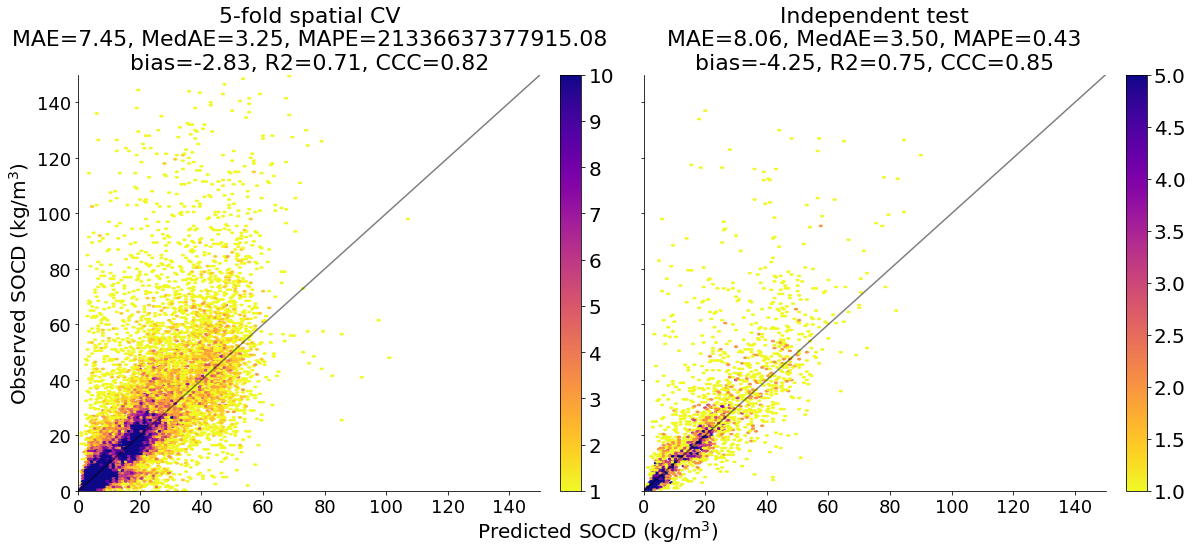

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming mae_cv, r2_cv, ccc_cv, y_cv, train[prop], mae_val, r2_val, ccc_val, y_val, test[prop] are already defined

show_low = 0
show_high = 150

x_min, x_max = 0, 150
y_min, y_max = 0, 150

fig, axs = plt.subplots(1, 2, figsize=(17, 8))  # 17x8 inches figure with two subplots

# Update rcParams for global font size settings
plt.rcParams.update({'font.size': 20})

# Plot the first accuracy plot
axs[0].set_title(f'5-fold spatial CV\nMAE={mae_cv:.2f}, MedAE={medae_cv:.2f}, MAPE={mape_cv:.2f}\nbias={bias_cv:.2f}, R2={r2_cv:.2f}, CCC={ccc_cv:.2f}', fontsize=22)
hb1 = axs[0].hexbin(np.expm1(y_cv), train[prop], gridsize=(150, 150), extent=[x_min, x_max, y_min, y_max], cmap='plasma_r', mincnt=1, vmax=10)  # Change 'plasma_r' to 'plasma'
# axs[0].set_xlabel('Predicted SOCD (mg/cm$^3$)', fontsize=20)
axs[0].set_ylabel('Observed SOCD (kg/m$^3$)', fontsize=20)
axs[0].set_aspect('auto', adjustable='box')
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)
axs[0].plot([show_low, show_high], [show_low, show_high], "-k", alpha=.5)
axs[0].tick_params(labelsize=18)
axs[0].set_xlim([show_low, show_high])
axs[0].set_ylim([show_low, show_high])

# Plot the second accuracy plot
axs[1].set_title(f'Independent test\nMAE={mae_val:.2f}, MedAE={medae_val:.2f}, MAPE={mape_val:.2f}\nbias={bias_val:.2f}, R2={r2_val:.2f}, CCC={ccc_val:.2f}', fontsize=22)
hb2 = axs[1].hexbin(np.expm1(y_val), test[prop], gridsize=(150, 150), extent=[x_min, x_max, y_min, y_max], cmap='plasma_r', mincnt=1, vmax=5)  # Change 'plasma_r' to 'plasma'
# Hide y-axis label on the right plot
# axs[1].set_ylabel('Observed SOCD (mg/cm$^3$)', fontsize=20)
axs[1].set_aspect('auto', adjustable='box')
axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)
axs[1].plot([show_low, show_high], [show_low, show_high], "-k", alpha=.5)
axs[1].tick_params(labelsize=18)
axs[1].set_xlim([show_low, show_high])
axs[1].set_ylim([show_low, show_high])

# Remove the right y-axis labels
axs[1].tick_params(axis='y', labelleft=False)

# Set a shared x-label for both subplots
fig.text(0.5, 0.04, 'Predicted SOCD (kg/m$^3$)', ha='center', fontsize=20)

# Create a colorbar for each subplot
cbar1 = fig.colorbar(hb1, ax=axs[0], fraction=0.046, pad=0.04)
cbar2 = fig.colorbar(hb2, ax=axs[1], fraction=0.046, pad=0.04)

# Adjust layout and save the figure
plt.tight_layout(rect=[0, 0.04, 1, 1])
# plt.savefig(f'/home/opengeohub/xuemeng/work_xuemeng/soc/result_paper/plot_ocd_accuracy.pdf', format='pdf', bbox_inches='tight', dpi=300)

# Show the plot if desired
plt.show()


In [19]:
cal_size = 3678
train_size = 16124
test_size = 2626

In [23]:
cal_size/(train_size+test_size+cal_size)

0.16399143927233814

In [24]:
train_size/(train_size+test_size+cal_size)

0.7189227751025504

In [27]:
test_size/train_size

0.1628628131977177

In [9]:
y_val = np.expm1(y_val)

In [12]:
depth = [0,20,50,100]

for idep in [1,2,3]:
    temp = test.loc[(test['hzn_dep']>depth[idep-1]) & (test['hzn_dep']<=depth[idep])]
    print('mean')
    print(temp['ocd'].mean(), temp['pred'].mean())
    
    print('median')
    print(temp['ocd'].median(), temp['pred'].median())

mean
31.955896085231416 28.49597020765751
median
25.8048 25.381888992249586
mean
14.932767724867723 11.920411918284737
median
9.2353 9.056672870092058
mean
7.98452170940171 5.688685730440922
median
3.4066999999999994 3.98958681296583


### split training and test set first

In [21]:
# # data
# train = pd.read_csv(f'{output_folder}/benchmark_train.pnts_{prop}.csv',low_memory=False)
# # train = train.dropna(subset=covs+[tgt],how='any')
# test = pd.read_csv(f'{output_folder}/benchmark_test.pnts_{prop}.csv',low_memory=False)
# # test = test.dropna(subset=covs+[tgt],how='any')
# cal = pd.read_csv(f'{output_folder}/benchmark_cal.pnts_{prop}.csv',low_memory=False)
# # cal = cal.dropna(subset=covs+[tgt],how='any')

# tt = pd.concat([train,test])
# # tt = tt.loc[tt['tile_id'].notna()]
# train_tt, test_tt = train_test_split(tt, test_size=0.14, random_state=42)
# # from sklearn.model_selection import StratifiedShuffleSplit
# # sss = StratifiedShuffleSplit(n_splits=1, test_size=0.14, random_state=42)

# # for train_index, test_index in sss.split(tt, tt['tile_id']):
# #     train_tt = tt.iloc[train_index]
# #     test_tt = tt.iloc[test_index]


# train_tt.to_csv('/home/opengeohub/xuemeng/work_xuemeng/soc/result_paper/data_ocd_train.csv',index=False)
# test_tt.to_csv('/home/opengeohub/xuemeng/work_xuemeng/soc/result_paper/data_ocd_test.csv',index=False)